# XSVS pipeline

"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

## NSLS2 data retrieval imports

In [2]:
from databroker import DataBroker as db, get_images, get_table, get_events
from filestore.api import register_handler, deregister_handler
from filestore.retrieve import _h_registry, _HANDLER_CACHE

In [2]:
hdr = db[{{ uid }}]

NameError: name 'uid' is not defined

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import time

## Lazy Eiger Handler (later will goto databroker)


In [4]:
import h5py
from filestore.retrieve import HandlerBase
from eiger_io.pims_reader import EigerImages

EIGER_MD_DICT = {
    'y_pixel_size': 'entry/instrument/detector/y_pixel_size',
    'x_pixel_size': 'entry/instrument/detector/x_pixel_size',
    'detector_distance': 'entry/instrument/detector/detector_distance',
    'incident_wavelength': 'entry/instrument/beam/incident_wavelength',
    'frame_time': 'entry/instrument/detector/frame_time',
    'beam_center_x': 'entry/instrument/detector/beam_center_x',
    'beam_center_y': 'entry/instrument/detector/beam_center_y',
    'count_time': 'entry/instrument/detector/count_time',
    'binary_mask': 'entry/instrument/detector/detectorSpecific/pixel_mask',
}

class FixedEigerImages(EigerImages):
    def __init__(self, path, metadata):
        super().__init__(path)
        self._metadata = metadata
    
    @property
    def md(self):
        return self._metadata
    
    @property
    def dtype(self):
        return self.pixel_type
    
    @property
    def shape(self):
        return self.frame_shape

class LazyEigerHandler(HandlerBase):
    specs = {'AD_EIGER'} | HandlerBase.specs
    def __init__(self, fpath, frame_per_point, mapping=None):
        # create pims handler
        self.vals_dict = EIGER_MD_DICT.copy()
        if mapping is not None:
            self.vals_dict.update(mapping)
        self._base_path = fpath
        self.fpp = frame_per_point

    def __call__(self, seq_id):
        import h5py
        master_path = '{}_{}_master.h5'.format(self._base_path, seq_id)
        md = {}
        print('hdf5 path = %s' % master_path)
        with h5py.File(master_path, 'r') as f:
            #md = {k: f[v].value for k, v in self.vals_dict.items()}
            md = {k: f[v][()] for k, v in self.vals_dict.items()}
        # the pixel mask from the eiger contains:
        # 1  -- gap
        # 2  -- dead
        # 4  -- under-responsive
        # 8  -- over-responsive
        # 16 -- noisy
        binary_mask = md['binary_mask']
        binary_mask[binary_mask>0] = 1
        binary_mask[binary_mask==0] = 2
        binary_mask[binary_mask==1] = 0
        binary_mask[binary_mask==2] = 1
        md['framerate'] = 1./md['frame_time']
        # TODO Return a multi-dimensional PIMS seq
        return FixedEigerImages(master_path, md)

deregister_handler('AD_EIGER')
_HANDLER_CACHE.clear()
register_handler('AD_EIGER', LazyEigerHandler)

In [5]:
#%matplotlib notebook
%matplotlib inline

## Get the events from uid

In [6]:
def print_attrs(name, obj):
    print(name)
    for key, val in obj.attrs.items():
        print("%s: %s" % (key, val))

In [7]:
uid = 'c423e856'
hdr = db[uid]

In [8]:
ev, = get_events(hdr, ['eiger_4M_cam_img_image_lightfield'], fill = True)

hdf5 path = /XF11ID/data/2015/10/30/915b6fb3-aaf6-44f0-a999_9092_master.h5


In [9]:
from datetime import datetime
dt = datetime.fromtimestamp(hdr['start'].time)
path ='/XF11ID/analysis' + '/%s/%s/%s/' % (dt.year, dt.month, dt.day)
path

'/XF11ID/analysis/2015/10/30/'

In [10]:
imgs = ev['data']['eiger_4M_cam_img_image_lightfield']
print (imgs)
Nimg=len(imgs)

<Frames>
Length: 2500 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16


In [11]:
imgs.md

{'beam_center_x': 840.0,
 'beam_center_y': 336.0,
 'binary_mask': array([[1, 1, 1, ..., 1, 1, 0],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]], dtype=uint32),
 'count_time': 0.0049999999,
 'detector_distance': 4.8400002,
 'frame_time': 0.00501,
 'framerate': 199.60079982206346,
 'incident_wavelength': 1.3794414,
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

## load a mask if exist

otherwise create a mask using Mask pipeline

In [13]:
mask = np.load(uid+"_mask.npy")
#mask = np.load( path +  str(uid)+"_mask.npy"))

## Plot the mask¶

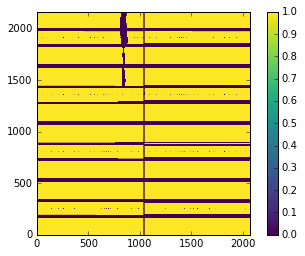

In [14]:
fig, ax = plt.subplots()
im=ax.imshow(mask, origin='lower' ,vmin=0,vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

## Interactive way to browse through images.
Note : Provide the number of images that you want to browse

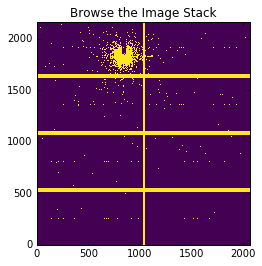

<function __main__.view_image>

In [15]:
from ipywidgets import interact
%matplotlib inline
def view_image(i):
    plt.imshow(imgs[i], interpolation='nearest', cmap='viridis',
               vmin=0, vmax=1e0, origin="lower")
    plt.title("Browse the Image Stack")
    plt.show()
    
interact(view_image, i=(0, 2499))

## Movie

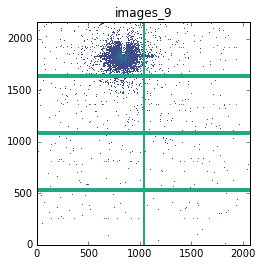

In [14]:
def view_image(sleeps=1, ims=0, ime = 1):    
    fig, ax = plt.subplots()  
    for i in range( ims, ime  ):
        ax.imshow(imgs[i],  interpolation='nearest', cmap='viridis',
                  origin='lower', norm= LogNorm( vmin=0.001, vmax=1e10 ) )
        ax.set_title("images_%s"%i)
        time.sleep( sleeps )
        plt.draw()
        
view_image(.2, 0, 10)

### hey, let's see if any images are bad!

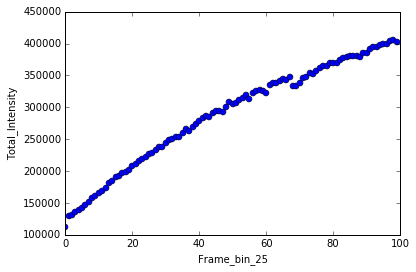

In [16]:
bin_img = 25
imgsum = [np.sum(img *mask) for img in imgs[::bin_img ]]

fig, ax = plt.subplots()  
ax.plot(imgsum,'bo')
ax.set_xlabel( 'Frame_bin_%s'%bin_img )
ax.set_ylabel( 'Total_Intensity' )
plt.show()

## Get the Averaged Image Data

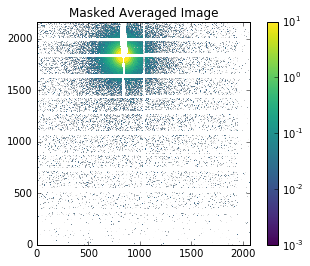

In [17]:
avg_img = np.average(imgs[::50], axis=0)*mask

img_mask = avg_img * mask

fig, ax = plt.subplots()
im = ax.imshow(img_mask, cmap='viridis',origin='lower',
               norm= LogNorm(vmin=0.001, vmax=1e1))
ax.set_title("Masked Averaged Image")
fig.colorbar(im)
plt.show()

## Note:  Obtain the following experiment information 

* The physical size of the pixels
* Wavelegth of the X-rays  - (units in Angstroms)
* Detector to sample distance
* Exposure time - (units in seconds)
* acqusition period - (units in seconds)
* dead time - (units in seconds)
* time per frame = (exposure time + dead_time or acqusition period) - (units in seconds)

In [18]:
# The physical size of the pixels
dpix = 0.075  
 
lambda_ = 1.5498    # wavelegth of the X-rays in Angstroms
Ldet = 5000.        # detector to sample distance

exposuretime= 100 * 10**(-3) 
acquisition_period = 100 * 10**(-3)  

#deadtime= 0   # 60e-6 
#timeperframe = exposuretime + deadtime
timeperframe = acquisition_period  

## Import all the required packages for  Data Analysis

* scikit-xray - data analysis tools for X-ray science 
    - https://github.com/scikit-xray/scikit-xray
* xray-vision - plotting helper functions for X-ray science
    - https://github.com/Nikea/xray-vision

In [19]:
import xray_vision
import xray_vision.mpl_plotting as mpl_plot  
from xray_vision.mask.manual_mask import ManualMask

import skxray.core.roi as roi
import skxray.core.speckle as speckle
import skxray.core.utils as utils

## Get the approximate center and see the statistic to make sure

In [20]:
imgs.md['beam_center_x'], imgs.md['beam_center_y']

(840.0, 336.0)

In [21]:
#center = (imgs.md['beam_center_x'], imgs.md['beam_center_y'])
center = [840, 1830]  # center of the speckle pattern
center=[center[1], center[0]]

center

[1830, 840]

## Create label array (Q rings)

### Circular Average : compute the radial integartion from the center of the speckle pattern

In [22]:
inner_radius = 60  # radius of the first ring
width = 2       # width of each ring
spacing =  (119 - 44)/9 - 2    # spacing between rings
num_rings = 6   # number of rings

#  find the edges of the required rings
edges = roi.ring_edges(inner_radius, width, spacing, num_rings)
edges

array([[  60.        ,   62.        ],
       [  68.33333333,   70.33333333],
       [  76.66666667,   78.66666667],
       [  85.        ,   87.        ],
       [  93.33333333,   95.33333333],
       [ 101.66666667,  103.66666667]])

In [23]:
two_theta = utils.radius_to_twotheta(Ldet, edges*dpix)
q_ring_val = utils.twotheta_to_q(two_theta, lambda_)

q_ring_center = np.average(q_ring_val, axis=1)
q_ring_center

array([ 0.00370958,  0.00421636,  0.00472313,  0.0052299 ,  0.00573668,
        0.00624345])

In [24]:
rings = roi.rings(edges, center, avg_img.shape)

ring_mask = rings*mask

## Extract the labeled array

In [25]:
labels, indices = roi.extract_label_indices(ring_mask)
labels

array([6, 6, 6, ..., 6, 6, 6])

In [26]:
indices

array([3575720, 3577782, 3577783, ..., 3991833, 3993899, 3993900])

## Number of pixels in each q ring

In [27]:
nopr = np.bincount( np.array(labels, dtype=int) )[1:]
nopr

array([441, 552, 622, 757, 876, 949])

#### Plot the labled array

AttributeError: 'module' object has no attribute 'show_label_array_on_image'

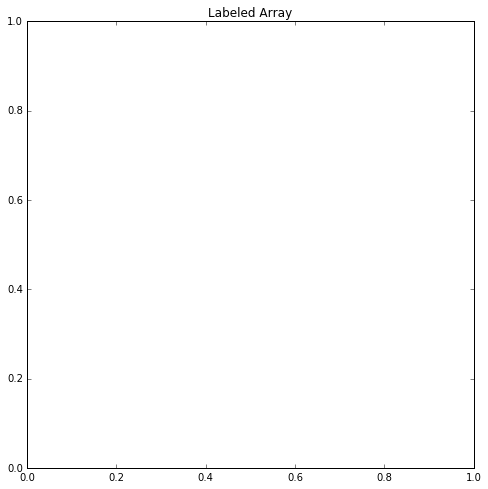

In [28]:
rings = roi.rings(edges, center, avg_img.shape)

ring_mask = rings*mask
#% matplotlib notebook
# plot the figure
fig, axes = plt.subplots(figsize=(8,8))
axes.set_title("Labeled Array")
#im = mpl_plot.show_label_(axes, ring_mask, cmap='viridis', origin="lower")
im = mpl_plot.show_label_array_on_image(axes, avg_img, ring_mask, cmap='viridis',
                              imshow_cmap='gray', norm=LogNorm())
plt.show()

In [29]:
def show_label_array_on_image(ax, image, label_array, cmap=None,
                              imshow_cmap='gray', norm=LogNorm(), **kwargs):
    """
    This will plot the required ROI's(labeled array) on the image
    Additional kwargs are passed through to `ax.imshow`.
    If `vmin` is in kwargs, it is clipped to minimum of 0.5.
    Parameters
    ----------
    ax : Axes
        The `Axes` object to add the artist too
    image : array
        The image array
    label_array : array
        Expected to be an unsigned integer array.  0 is background,
        positive integers label region of interest
    cmap : str or colormap, optional
        Color map to use for plotting the label_array, defaults to 'None'
    imshow_cmap : str or colormap, optional
        Color map to use for plotting the image, defaults to 'gray'
    norm : str, optional
        Normalize scale data, defaults to 'Lognorm()'
    Returns
    -------
    im : AxesImage
        The artist added to the axes
    im_label : AxesImage
        The artist added to the axes
    """
    ax.set_aspect('equal')
    im = ax.imshow(image, cmap=imshow_cmap, interpolation='none', norm=norm,
                   **kwargs)
    im_label = mpl_plot.show_label_array(ax, label_array, cmap=cmap, norm=norm,
                                **kwargs)
    return im, im_label

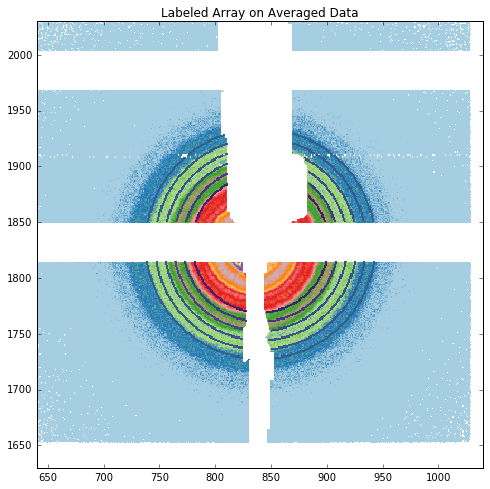

In [38]:
rings = roi.rings(edges, center, avg_img.shape)
ring_mask = rings*mask

# plot the figure
fig, axes = plt.subplots(figsize=(8,8))
axes.set_title("Labeled Array on Averaged Data")
im = show_label_array_on_image(axes, avg_img, ring_mask, cmap='viridis',
                            imshow_cmap='Paired', norm=LogNorm(), origin="lower")
rwidth = 200 
x1,x2 = [center[1] - rwidth, center[1] + rwidth]
y1,y2 = [center[0] - rwidth, center[0] + rwidth]
axes.set_xlim( [x1,x2])
axes.set_ylim( [y1,y2])

plt.show()

##  Mask the images

In [39]:
class Masker:
    def __init__(self, indexable, mask):
        self.indexable = indexable
        self.mask = mask
    def __getitem__(self, key):
        return self.indexable[key] * mask
    
    
masker = Masker(imgs, mask)

##  Mean intensities for each ring

In [40]:
n = 50
mean_int_sets, index_list = roi.mean_intensity(masker[::50], ring_mask)

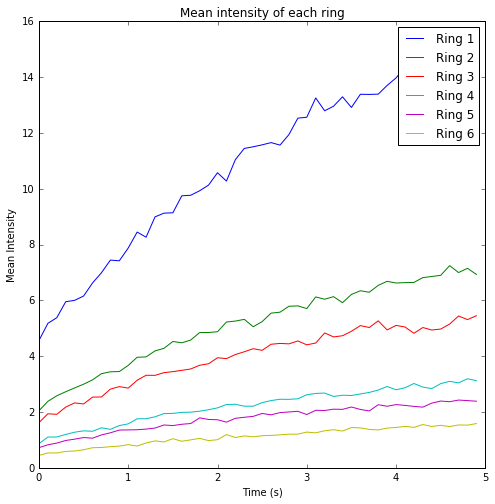

In [41]:
time = np.arange(len(imgs[::n]))*timeperframe  # get the time for each frame

%matplotlib inline
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_title("Mean intensity of each ring")
for i in range(num_rings):
    ax.plot(time, mean_int_sets[:,i], label="Ring "+str(i+1))
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Mean Intensity")
ax.legend() 
plt.show()

### Find the brightest pixel in any ROI in any image in the image set.
Using roi_max_counts function from skxray.core.roi module

In [ ]:
max_cts = roi.roi_max_counts(masker[::100], ring_mask)
max_cts

## XSVS analysis

#### Find the integration times¶
using skxray.core.utils.geometric_series

In [42]:
time_steps = utils.geometric_series(2, 30)
time_steps

[1, 2, 4, 8, 16]

In [43]:
spe_cts_all, std_dev = speckle.xsvs((masker,), ring_mask, timebin_num=2,
                             number_of_img=30, max_cts=20)

In [44]:
spe_cts_all.shape

(5, 6)

### get the bin edges

In [57]:
np.mean(np.linspace(1, 40, 40))

20.5

In [60]:
mean_values = np.array([10.5, 10.5, 10.5, 10.5, 10.5, 10.5])

In [61]:
num_times = spe_cts_all.shape[0]
num_rois = num_rings
norm_bin_edges, norm_bin_centers = speckle.normalize_bin_edges(num_times,
                                                               num_rois, mean_values,
                                                               max_cts=20)

### Plot the results for each q ring

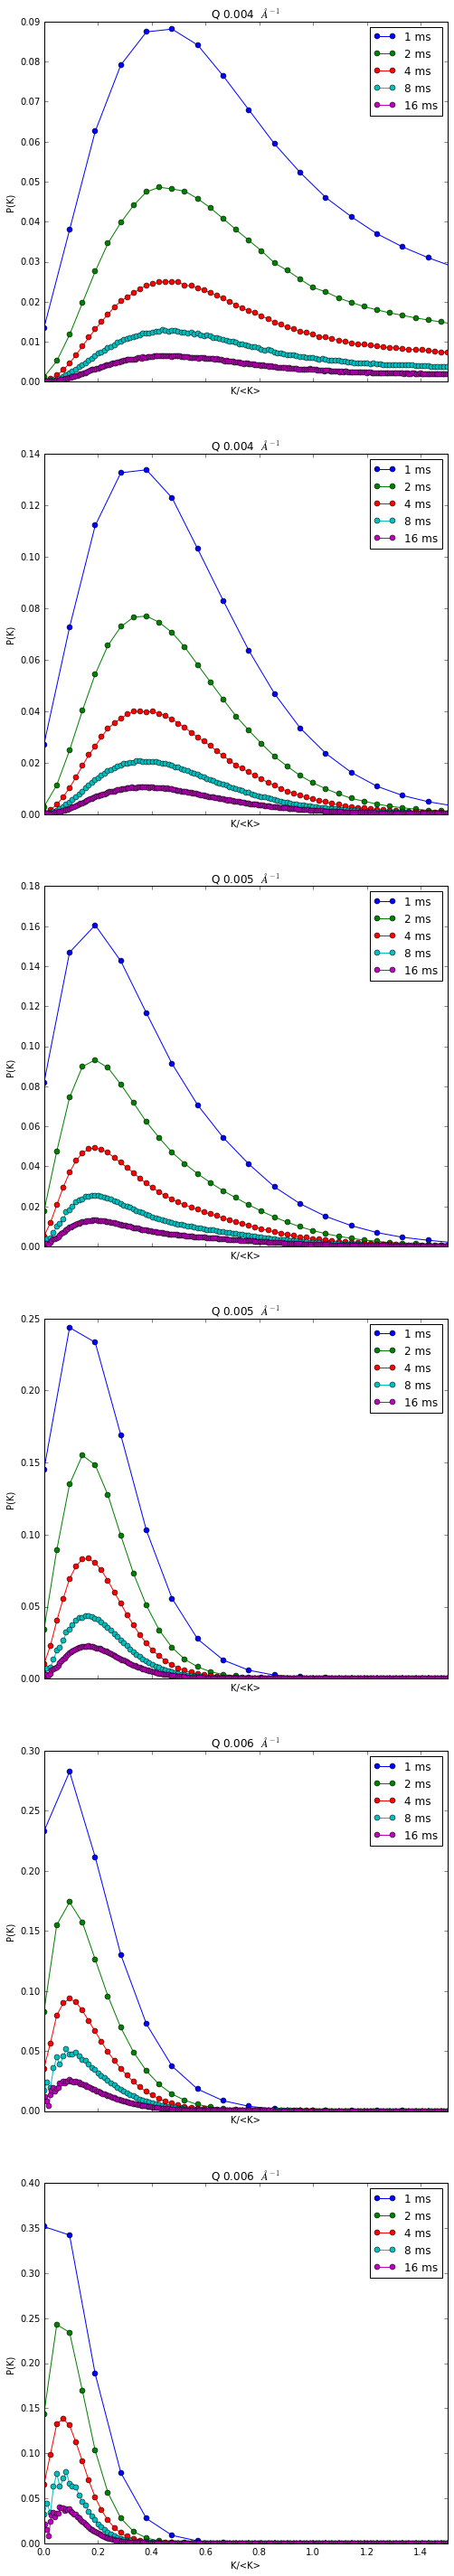

In [65]:
fig, axes = plt.subplots(num_rings, sharex=True, figsize=(8, 50))
#axes[num_rings-1].set_xlabel(r"$\tau,sec$", fontsize=22)
for i in range(num_rings):
    for j in range(num_times):
        axes[i].set_xlabel("K/<K>")
        axes[i].set_ylabel("P(K)")
        art, = axes[i].plot(norm_bin_edges[j, i][:-1], spe_cts_all[j, i], '-o',
                     label=str(time_steps[j])+" ms")
        axes[i].set_xlim(0, 1.5)
        axes[i].set_title("Q "+ '%.3f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
        axes[i].legend()
plt.show()

## Fit XSVS results

In [46]:
from scipy import stats
from scipy.special import gamma, gammaln

def gamma_dist(bin_values, K, M):
    """
    Gamma distribution function
    Parameters
    ----------
    bin_values : array
        scattering intensities
    K : int
        number of photons
    M : int
        number of coherent modes
    Returns
    -------
    gamma_dist : array
        Gamma distribution
    Notes
    -----
    These implementations are based on the references under
    nbinom_distribution() function Notes

    : math ::
        P(K) =(\frac{M}{<K>})^M \frac{K^(M-1)}{\Gamma(M)}\exp(-M\frac{K}{<K>})
    """

    gamma_dist = (stats.gamma(M, 0., K/M)).pdf(bin_values)
    return gamma_dist


def nbinom_dist(bin_values, K, M):
    """
    Negative Binomial (Poisson-Gamma) distribution function
    Parameters
    ----------
    bin_values : array
        scattering bin_values
    K : int
        number of photons
    M : int
        number of coherent modes
    Returns
    -------
    nbinom : array
        Negative Binomial (Poisson-Gamma) distribution function
    Notes
    -----
    The negative-binomial distribution function
    :math ::
        P(K) = \frac{\\Gamma(K + M)} {\\Gamma(K + 1) ||Gamma(M)}(\frac {M} {M + <K>})^M (\frac {<K>}{M + <K>})^K

    These implementation is based on following references

    References: text [1]_
    .. [1] L. Li, P. Kwasniewski, D. Oris, L Wiegart, L. Cristofolini,
       C. Carona and A. Fluerasu , "Photon statistics and speckle visibility
       spectroscopy with partially coherent x-rays" J. Synchrotron Rad.,
       vol 21, p 1288-1295, 2014.

    """
    co_eff = np.exp(gammaln(bin_values + M) -
                    gammaln(bin_values + 1) - gammaln(M))

    nbinom = co_eff * np.power(M / (K + M), M) * np.power(K / (M + K),
                                                          bin_values)
    return nbinom


def poisson_dist(bin_values, K):
    """
    Poisson Distribution
    Parameters
    ---------
    K : int
        number of photons
    bin_values : array
        scattering bin_values
    Returns
    -------
    poisson_dist : array
       Poisson Distribution
    Notes
    -----
    These implementations are based on the references under
    nbinom_distribution() function Notes
    :math ::
        P(K) = \frac{<K>^K}{K!}\exp(-K)
    """
    #poisson_dist = stats.poisson.pmf(K, bin_values)
    poisson_dist = np.exp(-K) * np.power(K, bin_values)/gamma(bin_values + 1)
    return poisson_dist

In [47]:
from lmfit import  Model

g_mod = Model(gamma_dist)
n_mod = Model(nbinom_dist)
p_mod = Model(poisson_dist)

In [54]:
max_cts=20

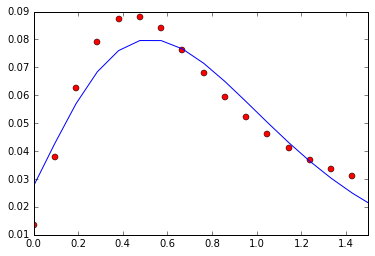

In [67]:
result_n = n_mod.fit(spe_cts_all[0, 0], bin_values=np.linspace(1, max_cts, max_cts)[1:], K=5, M=10)

plt.plot(norm_bin_edges[0, 0][:-1], spe_cts_all[0,0], 'ro')
plt.plot(norm_bin_edges[0, 0][:-1], result_n.best_fit, '-b')
plt.xlim(0, 1.5)
plt.show()

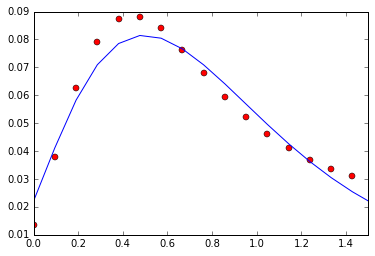

In [70]:
result_g = g_mod.fit(spe_cts_all[0, 0], bin_values=np.linspace(1, max_cts, max_cts)[1:], K=5, M=10)

plt.plot(norm_bin_edges[0, 0][:-1], spe_cts_all[0,0], 'ro')
plt.plot(norm_bin_edges[0, 0][:-1], result_g.best_fit, '-b')
plt.xlim(0, 1.5)
plt.show()

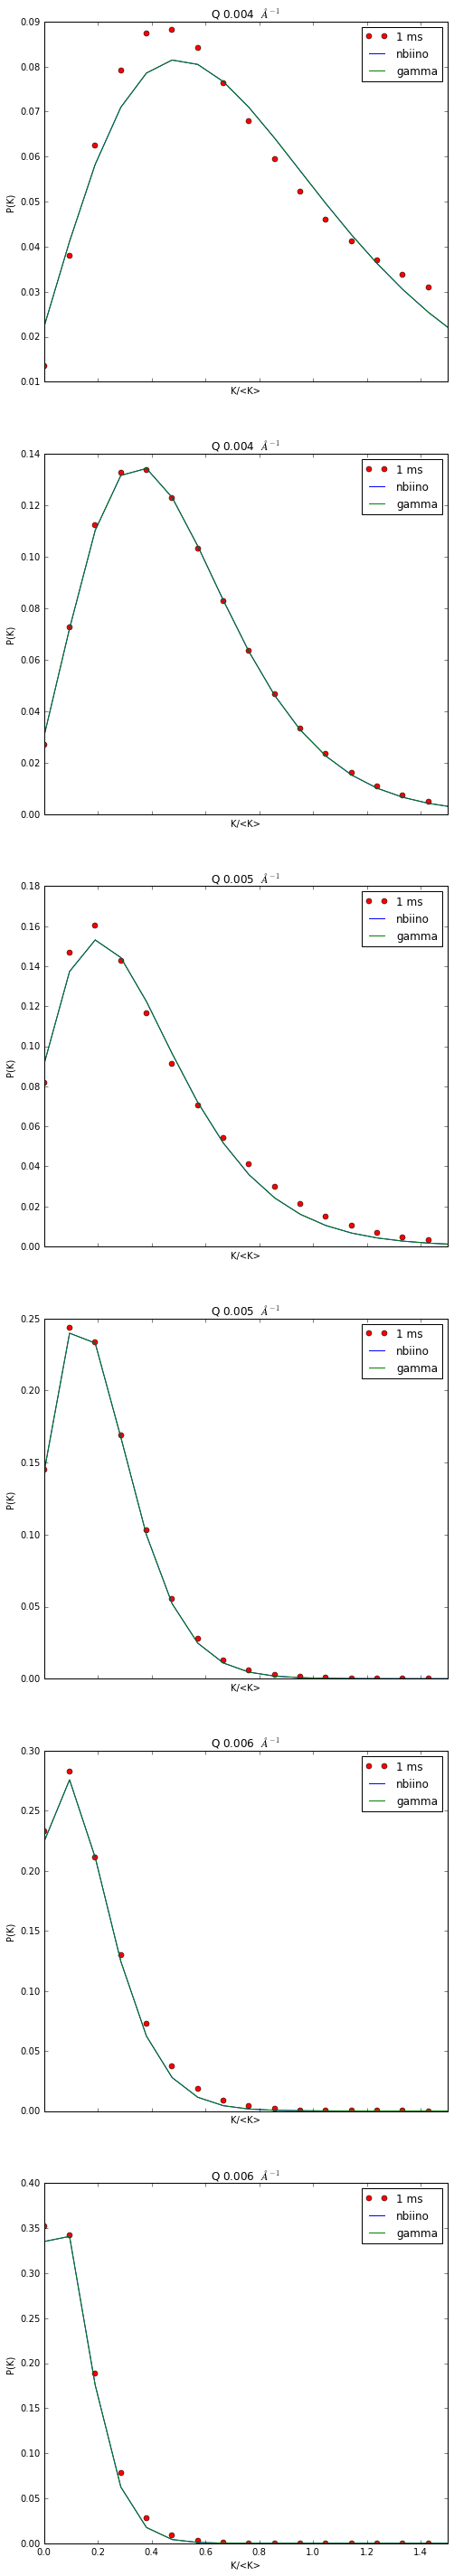

In [75]:
fig, axes = plt.subplots(num_rings, sharex=True, figsize=(8, 50))
#axes[num_rings-1].set_xlabel(r"$\tau,sec$", fontsize=22)
for i in range(num_rings):
    #for j in range(num_times):
        result_n = n_mod.fit(spe_cts_all[0, i],
                             bin_values=np.linspace(1, max_cts, max_cts)[1:],
                             K=5, M=10)
        result_g = g_mod.fit(spe_cts_all[0, i],
                             bin_values=np.linspace(1, max_cts, max_cts)[1:],
                             K=5, M=10)
        axes[i].set_xlabel("K/<K>")
        axes[i].set_ylabel("P(K)")
        art, = axes[i].plot(norm_bin_edges[0, i][:-1], spe_cts_all[0, i], 'ro',
                     label=str(time_steps[0])+" ms")
        art1, = axes[i].plot(norm_bin_edges[0, i][:-1], result_g.best_fit, '-b', label='nbiino')
        art2, = axes[i].plot(norm_bin_edges[0, i][:-1], result_g.best_fit, '-g', label='gamma')
        axes[i].set_xlim(0, 1.5)
        axes[i].set_title("Q "+ '%.3f  '%(q_ring_center[i])+ r'$\AA^{-1}$')
        axes[i].legend()
plt.show()